In [1]:
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly import tools

In [2]:
!apt-get install tree
!mkdir train_data test_data val_data train_data/yes train_data/no test_data/yes test_data/no val_data/yes val_data/no
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 0s (132 kB/s)
Selecting previously unselected package tree.
(Reading database ... 122519 files and directories currently installed.)
Preparing to unpack .../tree_1.8.0-1_amd64.deb ...
Unpacking tree (1.8.0-1) ...
Setting up tree (1.8.0-1) ...
Processing triggers for man-db (2.9.1-1) ...
.
├── sample_data
├── test_data
│   ├── no
│   └── yes
├── train_data
│   ├── no
│   └── yes
└── val_data
    ├── no
    └── yes

10 directories


In [3]:
import zipfile

In [4]:
ZIP_PATH = './brain_tumor_dataset.zip'
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall('./')

In [5]:
data_path = './brain_tumor_dataset/'
for dir in os.listdir(data_path):
    if not dir.startswith('.'):
        image_count = len(os.listdir(data_path + dir))
        for (n, file) in enumerate(os.listdir(data_path + dir)):
            img = data_path + dir + '/' + file
            if n < 5:
                shutil.copy(img, 'test_data/' + dir + '/' + file)
            elif n < 0.8*image_count:
                shutil.copy(img, 'train_data/'+ dir + '/' + file)
            else:
                shutil.copy(img, 'val_data/'+ dir + '/' + file)

# **2. Data Importing and Preprocessing**

In [6]:
import numpy as np 
from tqdm import tqdm
import cv2

In [7]:
def load_images(directory, img_size=(100,100)):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(directory))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(directory + path):
                if not file.startswith('.'):
                    img = cv2.imread(directory + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {directory} directory.')
    return X, y, labels


In [8]:
train_dir = 'train_data/'
test_dir = 'test_data/'
val_dir = 'val_data/'
image_size = (224,224)

X_train, y_train, labels = load_images(train_dir, image_size)
X_test, y_test, _ = load_images(test_dir, image_size)
X_val, y_val, _ = load_images(val_dir, image_size)

100%|██████████| 2/2 [00:00<00:00,  2.30it/s]
<ipython-input-7-15d5adbde61d>:15: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



193 images loaded from train_data/ directory.


100%|██████████| 2/2 [00:00<00:00, 56.89it/s]


10 images loaded from test_data/ directory.


100%|██████████| 2/2 [00:00<00:00, 10.80it/s]


50 images loaded from val_data/ directory.


In [9]:
class_counts = dict()
class_counts[0] = []
class_counts[1] = []

for set_name in (y_train, y_val, y_test):
    class_counts[0].append(np.sum(set_name == 0))
    class_counts[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=class_counts[0],
    name='No',
    marker=dict(color='#7fc97f'),
    opacity=0.7
)

trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=class_counts[1],
    name='Yes',
    marker=dict(color='#beaed4'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of Classes in Each Set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(barmode='stack')
fig.show()


In [10]:
def plot_samples(X, y, labels, n=50):
    index = 0
    while index < len(labels):
        label = labels[index]
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        fig, axes = plt.subplots(i, j, figsize=(15, 6))
        fig.suptitle('Tumor: {}'.format(label))
        axes = axes.flatten()
        img_index = 0
        while img_index < len(imgs):
            img = imgs[img_index]
            ax = axes[img_index]
            ax.imshow(img[0])
            ax.set_xticks([])
            ax.set_yticks([])
            img_index += 1
        plt.show()
        index += 1

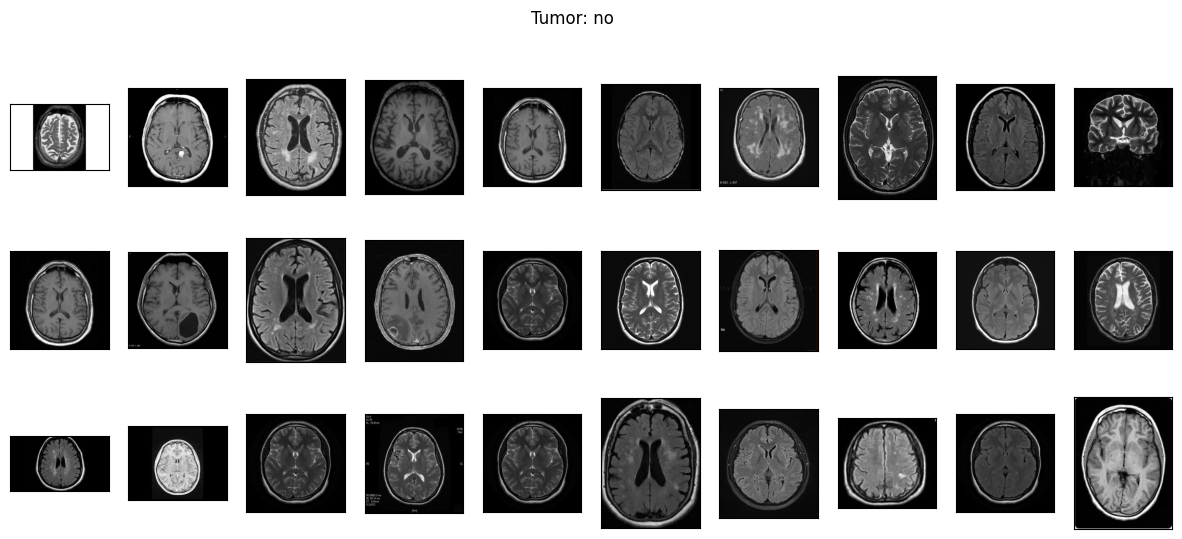

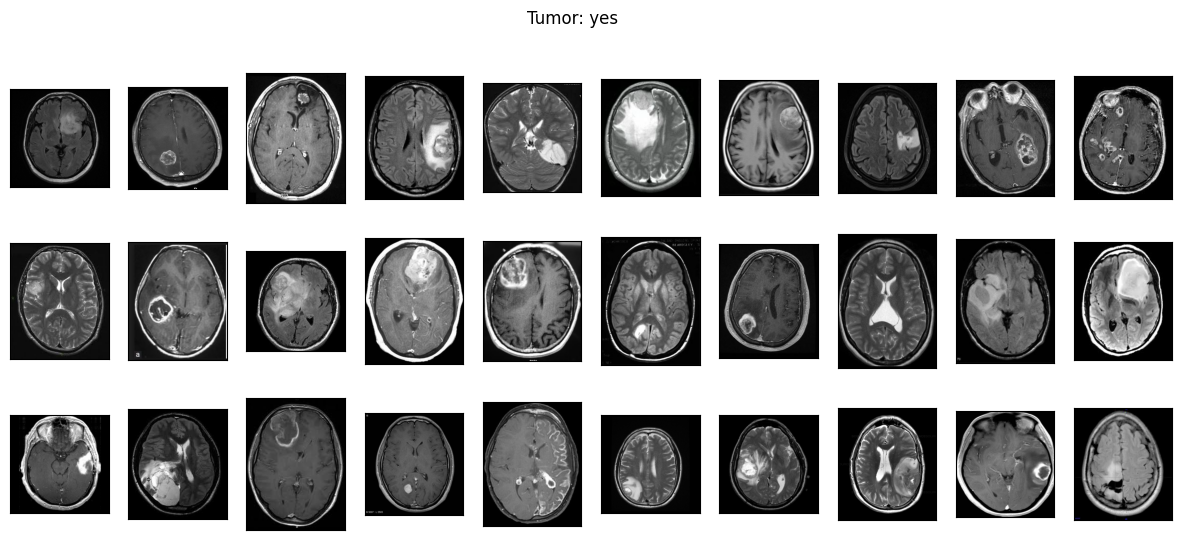

In [11]:
plot_samples(X_train, y_train, labels, 30)

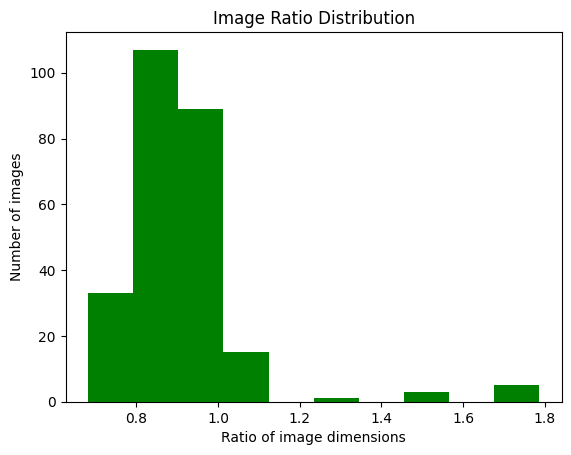

In [12]:
ratio_list = []
for set in (X_train, X_test, X_val):
    for img in set:
        ratio_list.append(img.shape[1]/img.shape[0])
        
plt.hist(ratio_list, color='green')
plt.title('Image Ratio Distribution')
plt.xlabel('Ratio of image dimensions')
plt.ylabel('Number of images')
plt.show()

In [13]:

def crop_images(set, add_pixels_value=0):

    new_set = []
    for img in set:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        new_img = img[extTop[1]-add_pixels_value:extBot[1]+add_pixels_value, extLeft[0]-add_pixels_value:extRight[0]+add_pixels_value].copy()
        new_set.append(new_img)

    return np.array(new_set)

In [14]:
img = cv2.imread('./brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=image_size,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

new_img = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()

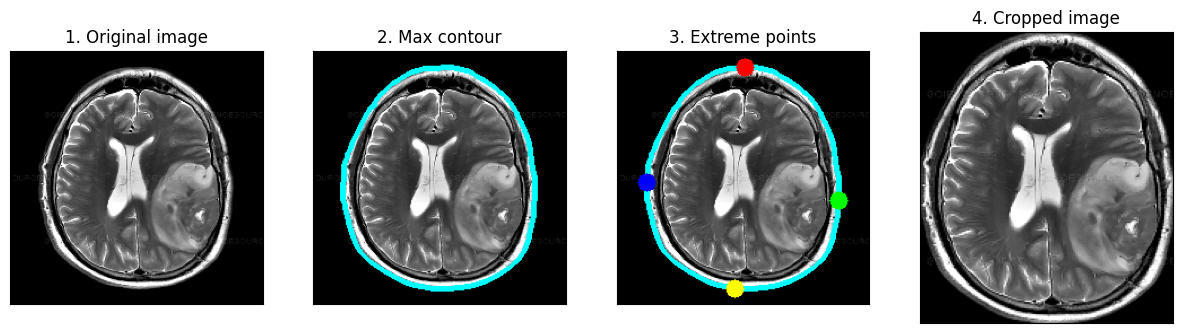

In [15]:

fig, axes = plt.subplots(1, 4, figsize=(15, 6))

images = [img, img_cnt, img_pnt, new_img]
titles = ['1. Original image', '2. Max contour',
          '3. Extreme points', '4. Cropped image']

for i in range(4):
    axes[i].imshow(images[i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(titles[i])

plt.show()

In [16]:
X_train_cropped = crop_images(set=X_train)
X_val_cropped= crop_images(set=X_val)
X_test_cropped = crop_images(set=X_test)

<ipython-input-13-8bd961553cf0>:24: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



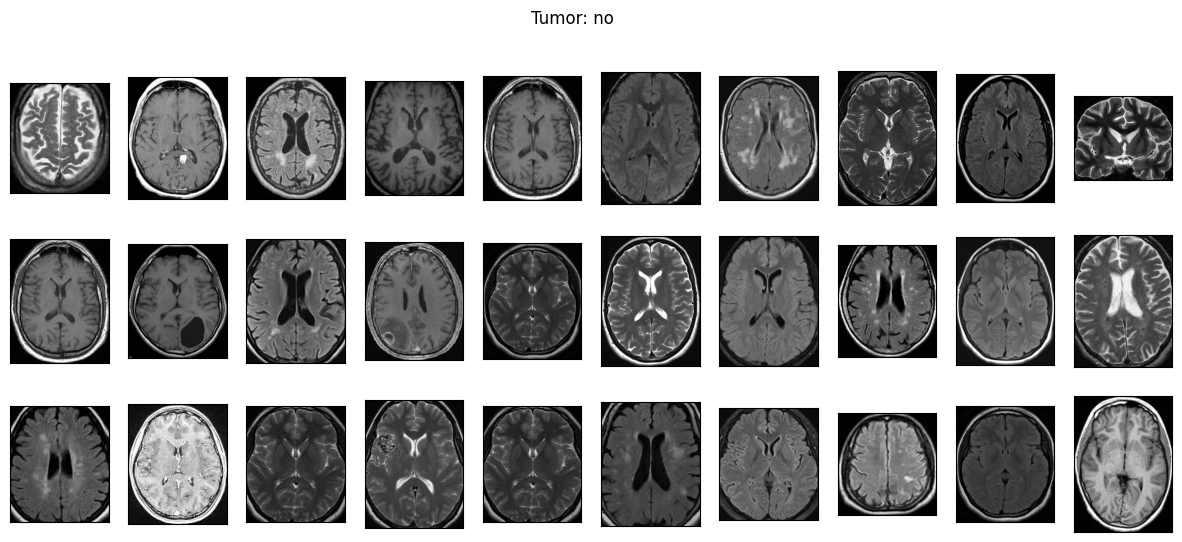

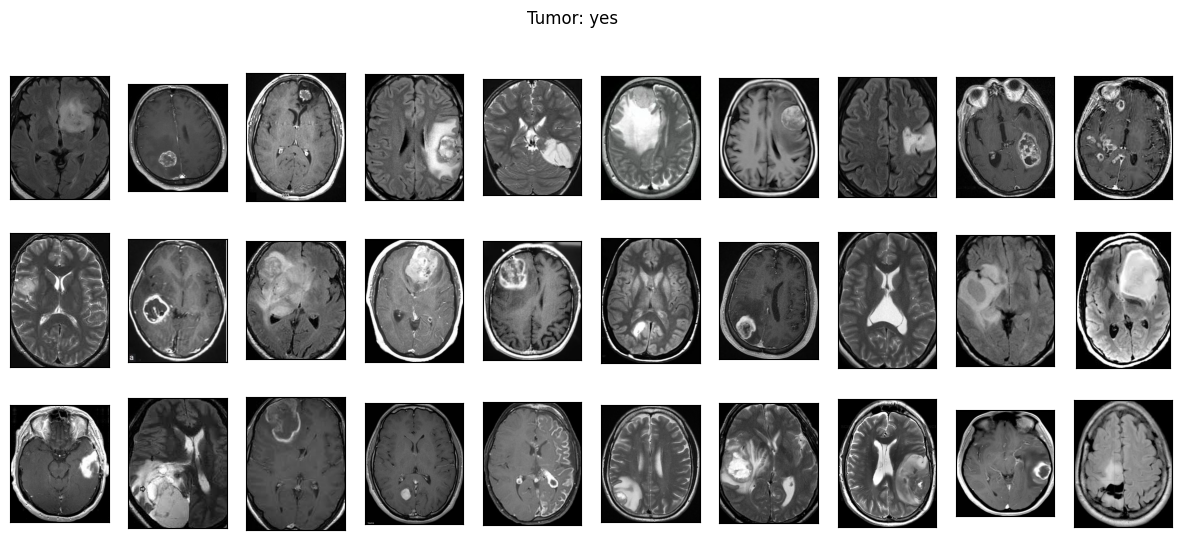

In [17]:
plot_samples(X_train_cropped, y_train, labels, 30)


In [18]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    while i < len(x_set):
        img, imclass = x_set[i], y_set[i]
        if imclass == 0:
            cv2.imwrite(folder_name+'no/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'yes/'+str(i)+'.jpg', img)
        i += 1

In [19]:
!mkdir train_cropped test_cropped val_cropped train_cropped/yes train_cropped/no test_cropped/yes test_cropped/no val_cropped/yes val_cropped/no

In [20]:
save_new_images(X_train_cropped, y_train, folder_name='train_cropped/')
save_new_images(X_test_cropped, y_test, folder_name='test_cropped/')
save_new_images(X_val_cropped, y_val, folder_name='val_cropped/')

In [21]:
from keras.applications.vgg16 import preprocess_input

In [22]:
def preprocess_imgs(set, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    new_set = []
    i = 0
    while i < len(set):
        img = set[i]
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        new_set.append(preprocess_input(img))
        i += 1
    return np.array(new_set)

In [23]:
X_train_preprocessed = preprocess_imgs(set=X_train_cropped, img_size=image_size)
X_test_preprocessed = preprocess_imgs(set=X_test_cropped, img_size=image_size)
X_val_preprocessed = preprocess_imgs(set=X_val_cropped, img_size=image_size)

# **Modeling**

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
RANDOM_SEED = 123

In [25]:
idg = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [26]:
os.mkdir('aug_img_samle')

In [27]:
x = X_train_cropped[0]  
x = x.reshape((1,) + x.shape) 

i = 0
while i <= 20:
    for batch in idg.flow(x, batch_size=1, save_to_dir='aug_img_samle', save_prefix='aug_img', save_format='jpg'):
        i += 1
        if i > 20:
            break

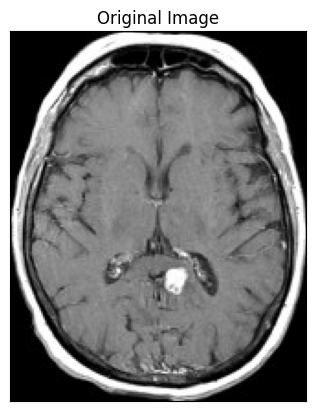

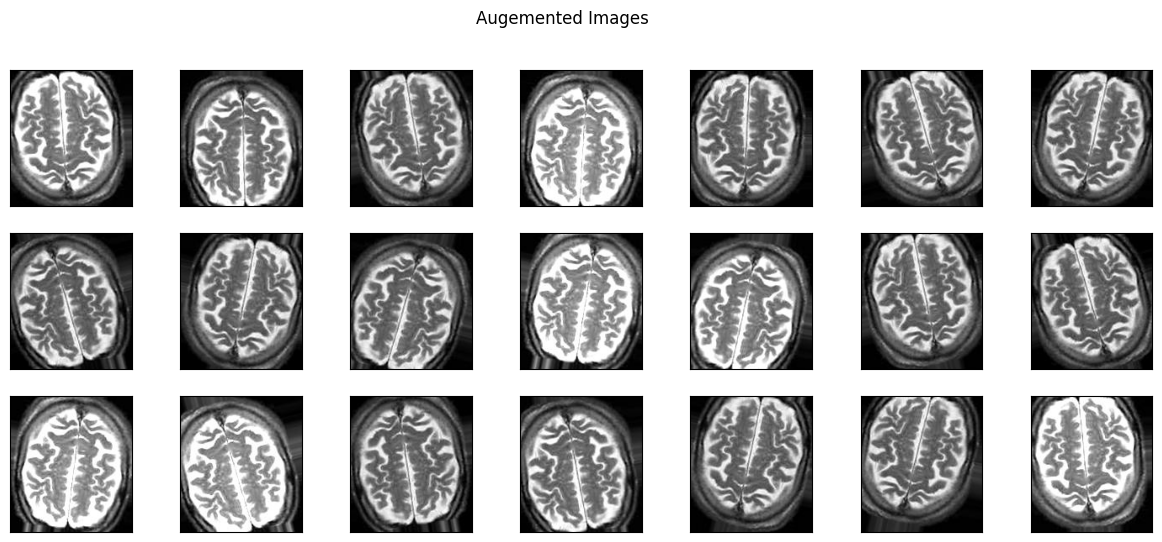

In [28]:
plt.imshow(X_train_cropped[1])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('aug_img_samle/'):
    img = cv2.imread('aug_img_samle/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [29]:
train_dir = 'train_cropped/'
val_dir = 'val_cropped/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',
    target_size=image_size,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    val_dir,
    color_mode='rgb',
    target_size=image_size,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [32]:
ZIP_PATH1 = './vgg16_weights_tf_dim_ordering_tf_kernels_notoph5.zip'
with zipfile.ZipFile(ZIP_PATH1, 'r') as zip_ref:
    zip_ref.extractall('./')

In [33]:
vgg16_weight_path = './vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    input_shape=image_size + (3,),
    weights=vgg16_weight_path,
    include_top=False
)

In [34]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [35]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=5,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

<ipython-input-35-cdfad770e874>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
5/5 [==============================] - ETA: 0s - loss: 5.1526 - accuracy: 0.5581 

5/5 [==============================] - 99s 24s/step - loss: 5.1526 - accuracy: 0.5581 - val_loss: 2.2215 - val_accuracy: 0.6400
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 3.5920 - accuracy: 0.6124 

5/5 [==============================] - 56s 10s/step - loss: 3.5920 - accuracy: 0.6124
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 4.0529 - accuracy: 0.6124 

5/5 [==============================] - 61s 11s/step - loss: 4.0529 - accuracy: 0.6124
Epoch 4/30
5/5 [==============================] - ETA: 0s - loss: 4.4299 - accuracy: 0.6357 

5/5 [==============================] - 59s 14s/step - loss: 4.4299 - accuracy: 0.6357
Epoch 5/30
5/5 [==============================] - ETA: 0s - loss: 4.3748 - accuracy: 0.6667 

5/5 [==============================] - 59s 11s/step - loss: 4.3748 - accuracy: 0.6667
Epoch 6/30
5/5 [==============================] - ETA: 0s - loss: 3.6805 - accuracy: 0.6512

5/5 [==============================] - 58s 11s/step - loss: 3.6805 - accuracy: 0.6512
Epoch 7/30
5/5 [==============================] - ETA: 0s - loss: 3.5984 - accuracy: 0.7132

5/5 [==============================] - 57s 11s/step - loss: 3.5984 - accuracy: 0.7132
Epoch 8/30
5/5 [==============================] - ETA: 0s - loss: 5.1373 - accuracy: 0.5969 

5/5 [==============================] - 57s 10s/step - loss: 5.1373 - accuracy: 0.5969
Epoch 9/30
5/5 [==============================] - ETA: 0s - loss: 3.3855 - accuracy: 0.6279 

5/5 [==============================] - 58s 14s/step - loss: 3.3855 - accuracy: 0.6279
Epoch 10/30
5/5 [==============================] - ETA: 0s - loss: 3.3420 - accuracy: 0.7000 

5/5 [==============================] - 72s 14s/step - loss: 3.3420 - accuracy: 0.7000
Epoch 11/30
5/5 [==============================] - ETA: 0s - loss: 4.2689 - accuracy: 0.6313 

5/5 [==============================] - 73s 15s/step - loss: 4.2689 - accuracy: 0.6313
Epoch 12/30
5/5 [==============================] - ETA: 0s - loss: 4.4205 - accuracy: 0.6124

5/5 [==============================] - 59s 11s/step - loss: 4.4205 - accuracy: 0.6124
Epoch 13/30
5/5 [==============================] - ETA: 0s - loss: 2.7363 - accuracy: 0.6512 

5/5 [==============================] - 58s 14s/step - loss: 2.7363 - accuracy: 0.6512
Epoch 14/30
5/5 [==============================] - ETA: 0s - loss: 3.4163 - accuracy: 0.6667 

5/5 [==============================] - 58s 11s/step - loss: 3.4163 - accuracy: 0.6667
Epoch 15/30
5/5 [==============================] - ETA: 0s - loss: 2.9292 - accuracy: 0.7250 

5/5 [==============================] - 71s 14s/step - loss: 2.9292 - accuracy: 0.7250
Epoch 16/30
5/5 [==============================] - ETA: 0s - loss: 3.3821 - accuracy: 0.6589

5/5 [==============================] - 58s 11s/step - loss: 3.3821 - accuracy: 0.6589
Epoch 17/30
5/5 [==============================] - ETA: 0s - loss: 1.9382 - accuracy: 0.7907 

5/5 [==============================] - 58s 14s/step - loss: 1.9382 - accuracy: 0.7907
Epoch 18/30
5/5 [==============================] - ETA: 0s - loss: 3.4232 - accuracy: 0.7132

5/5 [==============================] - 56s 11s/step - loss: 3.4232 - accuracy: 0.7132
Epoch 19/30
5/5 [==============================] - ETA: 0s - loss: 1.2503 - accuracy: 0.8217 

5/5 [==============================] - 57s 14s/step - loss: 1.2503 - accuracy: 0.8217
Epoch 20/30
5/5 [==============================] - ETA: 0s - loss: 2.1082 - accuracy: 0.7442 

5/5 [==============================] - 57s 14s/step - loss: 2.1082 - accuracy: 0.7442
Epoch 21/30
5/5 [==============================] - ETA: 0s - loss: 2.1524 - accuracy: 0.7812 

5/5 [==============================] - 71s 14s/step - loss: 2.1524 - accuracy: 0.7812
Epoch 22/30
5/5 [==============================] - ETA: 0s - loss: 1.9075 - accuracy: 0.7625 

5/5 [==============================] - 70s 14s/step - loss: 1.9075 - accuracy: 0.7625
Epoch 23/30
5/5 [==============================] - ETA: 0s - loss: 2.4172 - accuracy: 0.7674

5/5 [==============================] - 58s 11s/step - loss: 2.4172 - accuracy: 0.7674
Epoch 24/30
5/5 [==============================] - ETA: 0s - loss: 3.6068 - accuracy: 0.6744

5/5 [==============================] - 57s 11s/step - loss: 3.6068 - accuracy: 0.6744
Epoch 25/30
5/5 [==============================] - ETA: 0s - loss: 2.7334 - accuracy: 0.7250 

5/5 [==============================] - 71s 14s/step - loss: 2.7334 - accuracy: 0.7250
Epoch 26/30
5/5 [==============================] - ETA: 0s - loss: 1.9976 - accuracy: 0.7519 

5/5 [==============================] - 57s 14s/step - loss: 1.9976 - accuracy: 0.7519
Epoch 27/30
5/5 [==============================] - ETA: 0s - loss: 2.5155 - accuracy: 0.7287

5/5 [==============================] - 59s 11s/step - loss: 2.5155 - accuracy: 0.7287
Epoch 28/30
5/5 [==============================] - ETA: 0s - loss: 2.4760 - accuracy: 0.7519 

5/5 [==============================] - 58s 14s/step - loss: 2.4760 - accuracy: 0.7519
Epoch 29/30
5/5 [==============================] - ETA: 0s - loss: 2.0466 - accuracy: 0.8062

5/5 [==============================] - 56s 11s/step - loss: 2.0466 - accuracy: 0.8062
Epoch 30/30
5/5 [==============================] - ETA: 0s - loss: 2.0411 - accuracy: 0.7875 

5/5 [==============================] - 71s 14s/step - loss: 2.0411 - accuracy: 0.7875


# **Performance check**

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

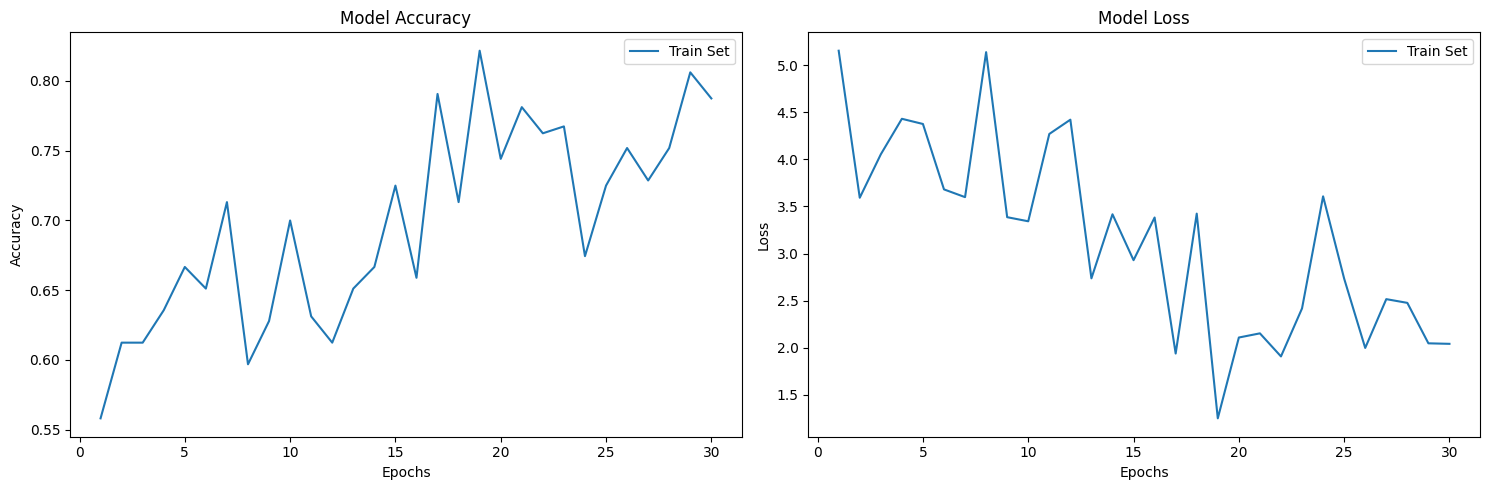

In [43]:
# plot model performance
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

2/2 [==============================] - 21s 7s/step
Val Accuracy = 0.78


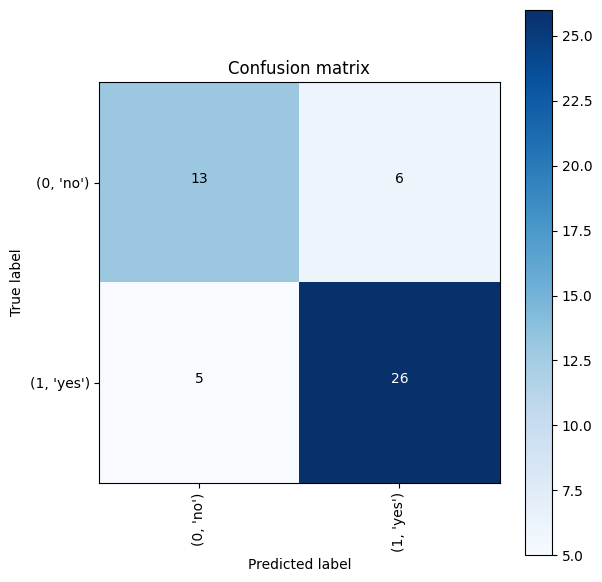

In [44]:
# validate on val set
predictions = model.predict(X_val_preprocessed)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

1/1 [==============================] - 4s 4s/step
Test Accuracy = 0.90


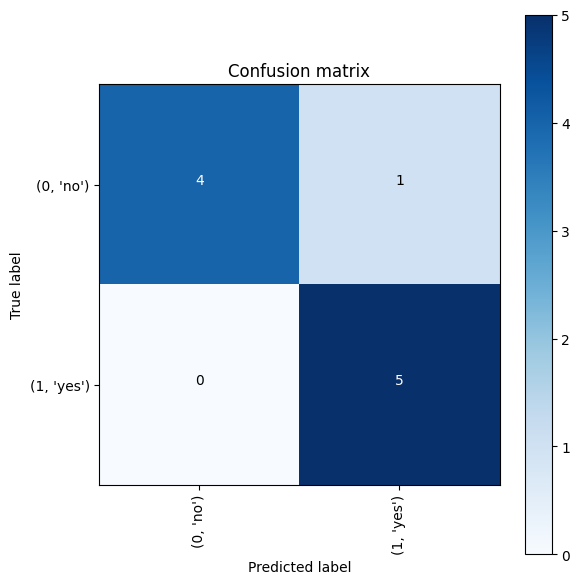

In [40]:
# validate on test set
predictions = model.predict(X_test_preprocessed)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)